In [1]:
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2
from jax import config
import jax.numpy as jnp
config.update("jax_enable_x64", True)

In [21]:
from opentn.states.qubits import X, Y, Z, I
import numpy as np
from opentn.transformations import lindbladian2super, super2choi, choi2kraus, vectorize_dissipative, create_2local_liouvillians, create_trotter_layers
from opentn.optimization import compute_trotter_approximation_error
import scipy
import matplotlib.pyplot as plt

p = 0.2
w =  1 - p 
gamma = -0.5 * np.log(1 - 2 * p)

In [10]:
test_super = (gamma/4) * (np.kron(X, X) - np.kron(I, I))
super_x =lindbladian2super(Li=[np.sqrt(gamma/4)*X])
if not np.allclose(test_super, super_x):
    print(test_super)
    print(super_x)
else:
    print(True)

True


In [11]:
test_super = (gamma/4) * (np.kron(Y, Y.conj()) - np.kron(I, I))
super_y = vectorize_dissipative(L=np.sqrt(gamma/4)*Y)
if not np.allclose(test_super, super_y):
    print(test_super)
    print(super_y)
else:
    print(True)

True


In [12]:
super_z =lindbladian2super(Li=[np.sqrt(gamma/4)*Z])
super_total = super_x + super_y + super_z
test_super_full = (gamma/4) * (np.kron(X, X) + np.kron(Y, Y.conj()) + np.kron(Z, Z) - 3*np.kron(I, I))
if not np.allclose(test_super_full, super_total):
    print(test_super_full)
    print(super_total)
else:
    print(True)
super_full_test = lindbladian2super(Li=[np.sqrt(gamma/4) * op for op in [X, Y, Z]])
np.allclose(super_full_test, super_total)

True


True

In [13]:
np.kron(Y, Y.conj()).imag, Y.imag

(array([[ 0.,  0., -0.,  0.],
        [ 0.,  0., -0., -0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.]]),
 DeviceArray([[ 0., -1.],
              [ 1.,  0.]], dtype=float64))

In [14]:
(lindbladian2super(Li=[np.sqrt(gamma/4) * op for op in [Y]]), test_super)

(array([[-0.25+0.j,  0.  +0.j,  0.  +0.j,  0.25+0.j],
        [ 0.  +0.j, -0.25+0.j, -0.25+0.j,  0.  +0.j],
        [ 0.  +0.j, -0.25+0.j, -0.25+0.j,  0.  +0.j],
        [ 0.25+0.j,  0.  +0.j,  0.  +0.j, -0.25+0.j]]),
 array([[-0.25+0.j,  0.  +0.j,  0.  +0.j,  0.25+0.j],
        [ 0.  +0.j, -0.25+0.j, -0.25-0.j,  0.  +0.j],
        [ 0.  +0.j, -0.25+0.j, -0.25+0.j,  0.  +0.j],
        [ 0.25+0.j,  0.  +0.j,  0.  +0.j, -0.25+0.j]]))

In [16]:
# Eks = choi2kraus(super2choi(exp_Lvec), tol=1e-15)
# len(Eks), Eks

In [146]:
np.sqrt(w**3 + (1-w)**3 + 2*(1-w)*w**2 + 2*w*(1-w)**2)

0.9165151389911681

# Creating Pauli lindbladians

In [9]:
# create a new sparse pauli lindbladian noise channel just to see whats up
# instead of the kitev lindbladian I should have paulis
N = 4
d = 2
tau = 1
gamma = 1

L0 = np.sqrt(gamma)*(np.kron(X, I) - np.kron(I, X))
L1 = np.sqrt(gamma)*(np.kron(Z, I) - np.kron(I, Z))
Li = [L0, L1]
# now to get the odd, even, and full layers for each of them and add them
Lvec_odd_full = jnp.zeros(shape=(d**(2*N), d**(2*N)), dtype=complex)
Lvec_even_full = jnp.zeros(shape=(d**(2*N), d**(2*N)), dtype=complex)

for op in Li:
   _, Lvec_odd, Lvec_even = create_2local_liouvillians(Li=op, N=N, d=d, pbc=True)    
   Lvec_odd_full += Lvec_odd
   Lvec_even_full += Lvec_even

Lvec_full = Lvec_odd_full + Lvec_even_full

In [18]:
exp_Lvec, exp_Lvec_odd, exp_Lvec_even = create_trotter_layers([Lvec_full, Lvec_odd_full, Lvec_even_full], tau=tau)
Eks = choi2kraus(super2choi(exp_Lvec), tol=1e-15)
print(len(Eks))
# interesting, it is actually what we expect I think.
Eks_even = choi2kraus(super2choi(exp_Lvec_even), tol=1e-15)
len(Eks_even)

256


100

# Now the optimization part

In [19]:
from opentn.stiefel import gradient_stiefel_vec, riemannian_hessian_vec, retract_stiefel
from opentn.optimization import frobenius_norm, model_stiefel_local
from opentn.trust_region_rcopt import riemannian_trust_region_optimize
f_stiefel = lambda xi: frobenius_norm(model_stiefel_local(xi, N, d), exp_Lvec)
grad_stiefel = lambda xi: gradient_stiefel_vec(xi, f_stiefel, metric='canonical')
hessian_stiefel = lambda xi: riemannian_hessian_vec(xi, f_stiefel, metric='canonical')

In [20]:
# now I need to create an ansatz as I did for get_kitaev_trotter_local_ansatz
from opentn.transformations import super2ortho
from opentn.optimization import get_general_trotter_local_ansatz
superop_local_list = get_general_trotter_local_ansatz(lindbladians=Li, tau=tau, n=2)
# just checking that now the rank has increase because we have more lindbladians.
# as expected, we have 2 lindbladians and we obtained 4 kraus operators?
print(np.linalg.matrix_rank(super2choi(superop_local_list[0])))
xs_timestep_2 = [super2ortho(x.real, rank=10) for x in superop_local_list]
print(f_stiefel(xs_timestep_2))

10
0.025364389491241437


In [265]:
xs_timestep_1 = [super2ortho(x.real, rank=10) for x in get_general_trotter_local_ansatz(lindbladians=Li, tau=tau, n=1)]
print(np.linalg.matrix_rank(super2choi(get_general_trotter_local_ansatz(lindbladians=Li, tau=tau, n=1)[0])))
print(f_stiefel(xs_timestep_1))

10
0.11294517951068227


In [214]:
xs_timestep_1_opt, f_timestep_1_opt, radius_timestep_1_opt = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel, hessian_stiefel, xs_timestep_1, save_x=True, niter=20)

iteration: 0
column : 0
column : 1
column : 2
cost function: 0.11294517951068227
radius 0.02
iteration: 1
column : 0
column : 1
column : 2
cost function: 0.11227828473846403
radius 0.04
iteration: 2
column : 0
column : 1
column : 2
cost function: 0.11124027887142852
radius 0.08
iteration: 3
column : 0
column : 1
column : 2
cost function: 0.11014318479356361
radius 0.1
iteration: 4
column : 0
column : 1
column : 2
cost function: 0.10950271927346032
radius 0.1
iteration: 5
column : 0
column : 1
column : 2
cost function: 0.10944128179858796
radius 0.1
iteration: 6
column : 0
column : 1
column : 2
cost function: 0.10839773093187999
radius 0.1
iteration: 7
column : 0
column : 1
column : 2
cost function: 0.10388040427317645
radius 0.1
iteration: 8
column : 0
column : 1
column : 2
cost function: 0.07727139116891082
radius 0.1
iteration: 9
column : 0
column : 1
column : 2
cost function: 0.05324364413341802
radius 0.1
iteration: 10
column : 0
column : 1
column : 2
cost function: 0.0428471166557

In [224]:
xs_timestep_1_opt_2, f_timestep_1_opt_2, radius_timestep_1_opt_2 = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel, hessian_stiefel, xs_timestep_1_opt[-1], save_x=True, niter=20, radius_init=radius_timestep_1_opt)

iteration: 0
column : 0
column : 1
column : 2
cost function: 0.011334572283685607
radius 0.05
iteration: 1
column : 0
column : 1
column : 2
cost function: 0.009933255201191047
radius 0.1
iteration: 2
column : 0
column : 1
column : 2
cost function: 0.009334232058841289
radius 0.1
iteration: 3
column : 0
column : 1
column : 2
cost function: 0.008706147560918417
radius 0.1
iteration: 4
column : 0
column : 1
column : 2
cost function: 0.008178784458594986
radius 0.1
iteration: 5
column : 0
column : 1
column : 2
cost function: 0.007708222383840513
radius 0.1
iteration: 6
column : 0
column : 1
column : 2
cost function: 0.0073600536539687525
radius 0.1
iteration: 7
column : 0
column : 1
column : 2
cost function: 0.007100080100464827
radius 0.1
iteration: 8
column : 0
column : 1
column : 2
cost function: 0.006806139290647465
radius 0.1
iteration: 9
column : 0
column : 1
column : 2
cost function: 0.006613313308198138
radius 0.025
iteration: 10
column : 0
column : 1
column : 2
cost function: 0.00

In [242]:
from opentn.stiefel import check_isometries
print(check_isometries(xs_timestep_1_opt_2[-1]))
for op in xs_timestep_1_opt_2[-1]:
    print(op.shape)

[True, True, True]
(40, 4)
(40, 4)
(40, 4)


In [217]:
xs_timestep_2_opt, f_timestep_2_opt, radius_timestep_2_opt = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel, hessian_stiefel, xs_timestep_2, save_x=True, niter=20)

iteration: 0
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.025364389491241437
radius 0.02
iteration: 1
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.024737191920668953
radius 0.04
iteration: 2
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.023722846514555883
radius 0.08
iteration: 3
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.02259987548024324
radius 0.1
iteration: 4
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.021864762933163064
radius 0.1
iteration: 5
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.021314025580864666
radius 0.1
iteration: 6
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.020822831100467724
radius 0.1
iteration: 7
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.02060339308308139
radius 0.1
iteration: 8
column : 0
column : 1
column : 2
column : 3
column : 4
cost functi

In [ ]:
0.025364389491241437

In [220]:
xs_timestep_2_opt_2, f_timestep_2_opt_2, radius_timestep_2_opt_2 = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel, hessian_stiefel, xs_timestep_2_opt[-1], save_x=True, niter=10, radius_init=radius_timestep_2_opt)

iteration: 0
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.004917628259244514
radius 0.1
iteration: 1
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.004445284378323082
radius 0.025
iteration: 2
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.004445284378323082
radius 0.05
iteration: 3
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.003970412480995393
radius 0.1
iteration: 4
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.0036078927984857256
radius 0.1
iteration: 5
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.003195232021839359
radius 0.1
iteration: 6
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.0028875606105185614
radius 0.025
iteration: 7
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.0028875606105185614
radius 0.025
iteration: 8
column : 0
column : 1
column : 2
column : 3
column : 4
co

In [227]:
xs_timestep_2_opt_3, f_timestep_2_opt_3, radius_timestep_2_opt_3 = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel, hessian_stiefel, xs_timestep_2_opt_2[-1], save_x=True, niter=10, radius_init=radius_timestep_2_opt_2)

iteration: 0
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.002317160550302309
radius 0.1
iteration: 1
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.002164754851191624
radius 0.1
iteration: 2
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.002061627362890593
radius 0.025
iteration: 3
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.002061627362890593
radius 0.025
iteration: 4
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.0018790776004952625
radius 0.05
iteration: 5
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.0018104945464819523
radius 0.1
iteration: 6
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.0017429407815954844
radius 0.025
iteration: 7
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.0017429407815954844
radius 0.05
iteration: 8
column : 0
column : 1
column : 2
column : 3
column : 4


In [230]:
xs_timestep_3 = [super2ortho(x.real, rank=10) for x in get_general_trotter_local_ansatz(lindbladians=Li, tau=tau, n=3)]
print(f_stiefel(xs_timestep_3))

0.010857033765052185


In [231]:
xs_timestep_3_opt, f_timestep_3_opt, radius_timestep_3_opt = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel, hessian_stiefel, xs_timestep_3, save_x=True, niter=20)

iteration: 0
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.010857033765052185
radius 0.02
iteration: 1
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.010437217250439269
radius 0.04
iteration: 2
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.009877584428447942
radius 0.08
iteration: 3
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.009482255059592295
radius 0.1
iteration: 4
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.009112739407732703
radius 0.1
iteration: 5
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.00834657156389041
radius 0.1
iteration: 6
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.007892306565641341
radius 0.1
iteration: 7
column : 0
column : 1
colu

In [234]:
xs_timestep_3_opt_2, f_timestep_3_opt_2, radius_timestep_3_opt_2 = riemannian_trust_region_optimize(
    f_stiefel, retract_stiefel, grad_stiefel, hessian_stiefel, xs_timestep_3_opt[-1], save_x=True, niter=20, radius_init=radius_timestep_3_opt)

iteration: 0
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.0021216495225596338
radius 0.1
iteration: 1
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.001969309682688608
radius 0.1
iteration: 2
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.001772324534805612
radius 0.1
iteration: 3
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.001586106577121945
radius 0.025
iteration: 4
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.001586106577121945
radius 0.025
iteration: 5
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.0014150562431183744
radius 0.05
iteration: 6
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.0013456700483884503
radius 0.1
iteration: 7
column : 0
column : 

In [235]:
ratios_ts_1 = [cost/f_timestep_1_opt[0] for cost in f_timestep_1_opt + f_timestep_1_opt_2]
ratios_ts_2 = [cost/f_timestep_2_opt[0] for cost in f_timestep_2_opt + f_timestep_2_opt_2 + f_timestep_2_opt_3]
ratios_ts_3 = [cost/f_timestep_3_opt[0] for cost in f_timestep_3_opt + f_timestep_3_opt_2]

In [373]:
f_timestep_2_opt[0] 

DeviceArray(0.02536439, dtype=float64)

In [371]:
error_suzuki = [compute_trotter_approximation_error(d, N, tau=1, n=n, Li=Li) for n in range(1,10)]
error_stiefel = [f_timestep_1_opt_2[-1], f_timestep_2_opt_3[-1], f_timestep_3_opt_2[-1]]

In [368]:
error_suzuki

[DeviceArray(0.11294518, dtype=float64),
 DeviceArray(0.02536439, dtype=float64),
 DeviceArray(0.01085703, dtype=float64),
 DeviceArray(0.00611177, dtype=float64),
 DeviceArray(0.00393854, dtype=float64),
 DeviceArray(0.00275278, dtype=float64),
 DeviceArray(0.00203275, dtype=float64),
 DeviceArray(0.00156235, dtype=float64),
 DeviceArray(0.00123808, dtype=float64)]

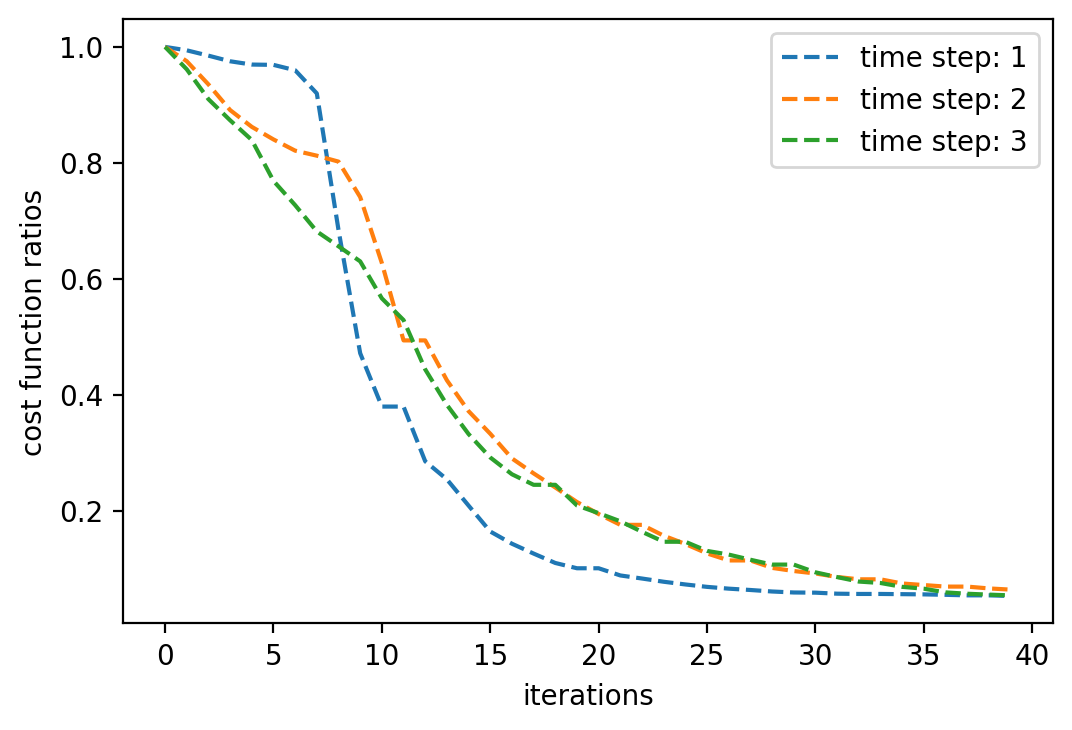

In [320]:
plt.figure(dpi=200)
plt.ylabel('cost function ratios')
plt.xlabel('iterations')
plt.plot(ratios_ts_1, '--', label='time step: 1')
plt.plot(ratios_ts_2, '--', label='time step: 2')
plt.plot(ratios_ts_3, '--', label='time step: 3')
plt.legend()

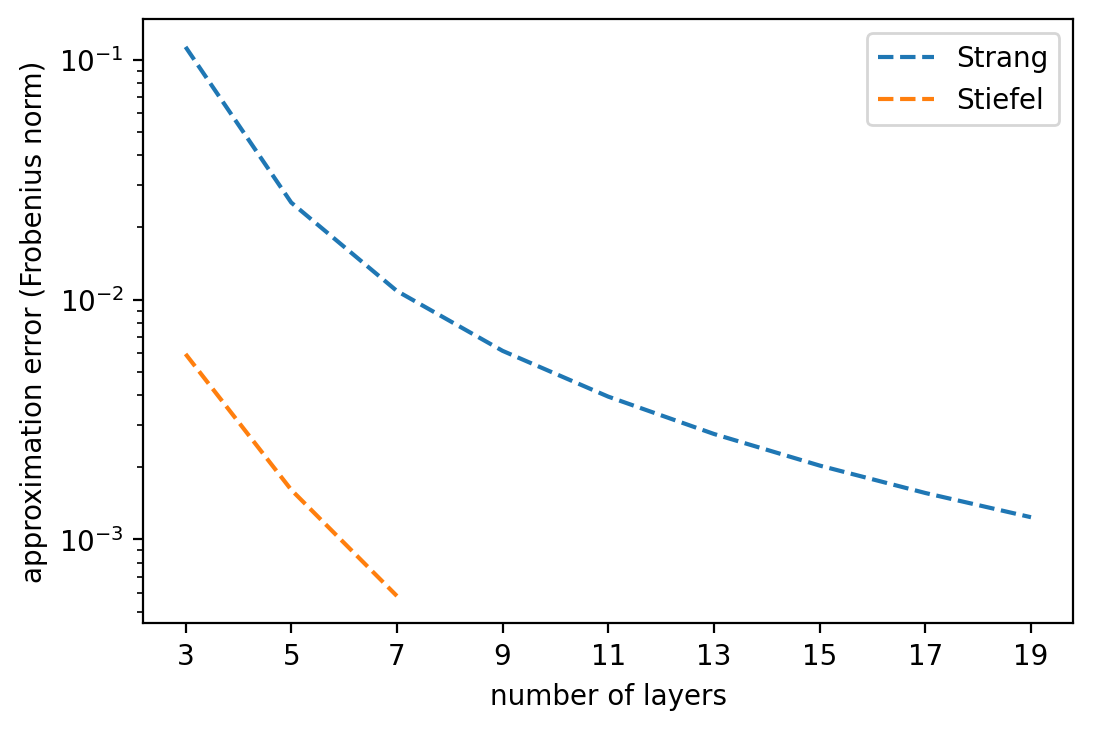

In [372]:
from opentn.utils import set_discrete_labels
fig = plt.figure(dpi=200)
ax = plt.gca()
plt.ylabel('approximation error (Frobenius norm)')
plt.xlabel('number of layers')
plt.semilogy(error_suzuki, '--', label='Strang')
plt.semilogy(error_stiefel, '--', label='Stiefel')
set_discrete_labels(labels=[str(index) for index in (2*np.arange(1,len(error_suzuki)+1) + 1)], ax=ax, rotation=0)
plt.legend()

# lets do the whole thing again but with different pauli channel

In [22]:
tau_sp = 4
gamma_sp = 2
L0 = np.sqrt(gamma_sp)*(np.kron(X, X))
L1 = np.sqrt(gamma_sp)*(np.kron(Z, Z))
Li_sp = [L0, L1]

Lvec_full_sp, Lvec_odd_full_sp, Lvec_even_full_sp = create_2local_liouvillians(Li=Li_sp, N=N, d=d, pbc=True)
exp_Lvec_sp, exp_Lvec_odd_sp, exp_Lvec_even_sp = create_trotter_layers([Lvec_full_sp, Lvec_odd_full_sp, Lvec_even_full_sp], tau=tau_sp)

Eks = choi2kraus(super2choi(exp_Lvec_sp), tol=1e-15)
print(len(Eks))
Eks_even = choi2kraus(super2choi(exp_Lvec_even_sp), tol=1e-15)
print(len(Eks_even))

f_stiefel_sp = lambda xi: frobenius_norm(model_stiefel_local(xi, N, d), exp_Lvec_sp)
grad_stiefel_sp = lambda xi: gradient_stiefel_vec(xi, f_stiefel_sp, metric='canonical')
hessian_stiefel_sp = lambda xi: riemannian_hessian_vec(xi, f_stiefel_sp, metric='canonical')

64
16


In [23]:
Lvec_odd_full_sp_test = jnp.zeros(shape=(d**(2*N), d**(2*N)), dtype=complex)
Lvec_even_full_sp_test = jnp.zeros(shape=(d**(2*N), d**(2*N)), dtype=complex)
for op in Li_sp:
   _, Lvec_odd, Lvec_even = create_2local_liouvillians(Li=op, N=N, d=d, pbc=True)    
   Lvec_odd_full_sp_test += Lvec_odd
   Lvec_even_full_sp_test += Lvec_even
Lvec_full_sp_test = Lvec_odd_full_sp_test + Lvec_even_full_sp_test
for op1, op2 in zip(create_2local_liouvillians(Li=Li_sp, N=N, d=d, pbc=True), [Lvec_full_sp_test, Lvec_odd_full_sp_test, Lvec_even_full_sp_test]):
    print(np.allclose(op1, op2))

True
True
True


In [24]:
rank_sp = np.linalg.matrix_rank(super2choi(get_general_trotter_local_ansatz(lindbladians=Li_sp, tau=tau, n=1)[0]))
rank_sp

4

In [366]:
xs_timestep_1_sp = [super2ortho(x.real, rank=rank_sp) for x in get_general_trotter_local_ansatz(lindbladians=Li_sp, tau=tau, n=1)]
print(f_stiefel_sp(xs_timestep_1_sp))

0.0023241536763024028


In [301]:
xs_timestep_1_sp_opt, f_timestep_1_sp_opt, radius_timestep_1_sp_opt = riemannian_trust_region_optimize(
    f_stiefel_sp, retract_stiefel, grad_stiefel_sp, hessian_stiefel_sp, xs_timestep_1_sp, save_x=True, niter=20)

0.0023241536763024028


In [306]:
len(xs_timestep_1_sp), np.allclose(xs_timestep_1_sp[0], xs_timestep_1_sp[2])

(3, True)

In [292]:
xs_timestep_2_sp = [super2ortho(x.real, rank=rank_sp) for x in get_general_trotter_local_ansatz(lindbladians=Li_sp, tau=tau, n=2)]
print(f_stiefel_sp(xs_timestep_2_sp))

xs_timestep_2_sp_opt, f_timestep_2_sp_opt, radius_timestep_2_sp_opt = riemannian_trust_region_optimize(
    f_stiefel_sp, retract_stiefel, grad_stiefel_sp, hessian_stiefel_sp, xs_timestep_2_sp, save_x=True, niter=20)

0.0023241536763024015
iteration: 0
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.0023241536763024015
radius 0.02
iteration: 1
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.0021150119929228047
radius 0.04
iteration: 2
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.001738802582541618
radius 0.08
iteration: 3
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.0011357341360306152
radius 0.1
iteration: 4
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.0006474767176926381
radius 0.025
iteration: 5
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.0006474767176926381
radius 0.00625
iteration: 6
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.0006474767176926381
radius 0.0015625
iteration: 7
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.0006474767176926381
radius 0.000390625
iteration: 8
column : 0
colu

In [318]:
len(xs_timestep_2_sp), np.allclose(xs_timestep_2_sp[1], xs_timestep_2_sp[3])

(5, True)

In [297]:
xs_timestep_2_sp_opt_2, f_timestep_2_sp_opt_2, radius_timestep_2_sp_opt_2 = riemannian_trust_region_optimize(
    f_stiefel_sp, retract_stiefel, grad_stiefel_sp, hessian_stiefel_sp, xs_timestep_2_sp_opt[-1], save_x=True, niter=20, radius_init=radius_timestep_2_sp_opt)

iteration: 0
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.00021017522595502184
radius 0.0015625
iteration: 1
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.00021017522595502184
radius 0.0015625
iteration: 2
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.00016454900125890254
radius 0.003125
iteration: 3
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.0001496618331500881
radius 0.00625
iteration: 4
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.00013962077090123707
radius 0.0125
iteration: 5
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 0.00012611367154199258
radius 0.025
iteration: 6
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 8.719163648140533e-05
radius 0.025
iteration: 7
column : 0
column : 1
column : 2
column : 3
column : 4
cost function: 5.626614184600908e-05
radius 0.00625
iteration: 8
column : 0
column : 1


In [322]:
xs_timestep_3_sp = [super2ortho(x.real, rank=rank_sp) for x in get_general_trotter_local_ansatz(lindbladians=Li_sp, tau=tau, n=3)]
print(f_stiefel_sp(xs_timestep_3_sp))

xs_timestep_3_sp_opt, f_timestep_3_sp_opt, radius_timestep_3_sp_opt = riemannian_trust_region_optimize(
    f_stiefel_sp, retract_stiefel, grad_stiefel_sp, hessian_stiefel_sp, xs_timestep_3_sp, save_x=True, niter=40)

0.0023241536763024084
iteration: 0
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.0023241536763024084
radius 0.02
iteration: 1
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.0021875912091689135
radius 0.04
iteration: 2
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.0019341730538746948
radius 0.08
iteration: 3
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.0014995514115975805
radius 0.1
iteration: 4
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.0008855869799755074
radius 0.1
iteration: 5
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.0005101877577164558
radius 0.025
iteration: 6
column : 0
column : 1
column : 2
column : 3
column : 4
column : 5
column : 6
cost function: 0.0005101877577164558
radius 0.00625
ite

In [325]:
ratios_ts_1_sp = [cost for cost in f_timestep_1_sp_opt]
ratios_ts_2_sp = [cost for cost in f_timestep_2_sp_opt + f_timestep_2_sp_opt_2]
ratios_ts_3_sp = [cost for cost in f_timestep_3_sp_opt]



In [356]:
error_suzuki_sp = [compute_trotter_approximation_error(d=d, N=N, tau=tau_sp, n=n, Li=Li_sp) for n in range(1,10)]
error_stiefel_sp = [values[-1] for values in [f_timestep_1_sp_opt, f_timestep_2_sp_opt_2, f_timestep_3_sp_opt]]

In [365]:
compute_trotter_approximation_error(d=d, N=N, tau=tau_sp, n=1, Li=Li_sp)

4


DeviceArray(2.32708612e-15, dtype=float64)

In [358]:
error_suzuki_sp

[DeviceArray(2.32708612e-15, dtype=float64),
 DeviceArray(2.75919174e-15, dtype=float64),
 DeviceArray(1.48692794e-15, dtype=float64),
 DeviceArray(1.62613598e-14, dtype=float64),
 DeviceArray(2.1490605e-14, dtype=float64),
 DeviceArray(4.00056334e-14, dtype=float64),
 DeviceArray(1.95649181e-14, dtype=float64),
 DeviceArray(5.86724662e-14, dtype=float64),
 DeviceArray(1.22600839e-14, dtype=float64)]

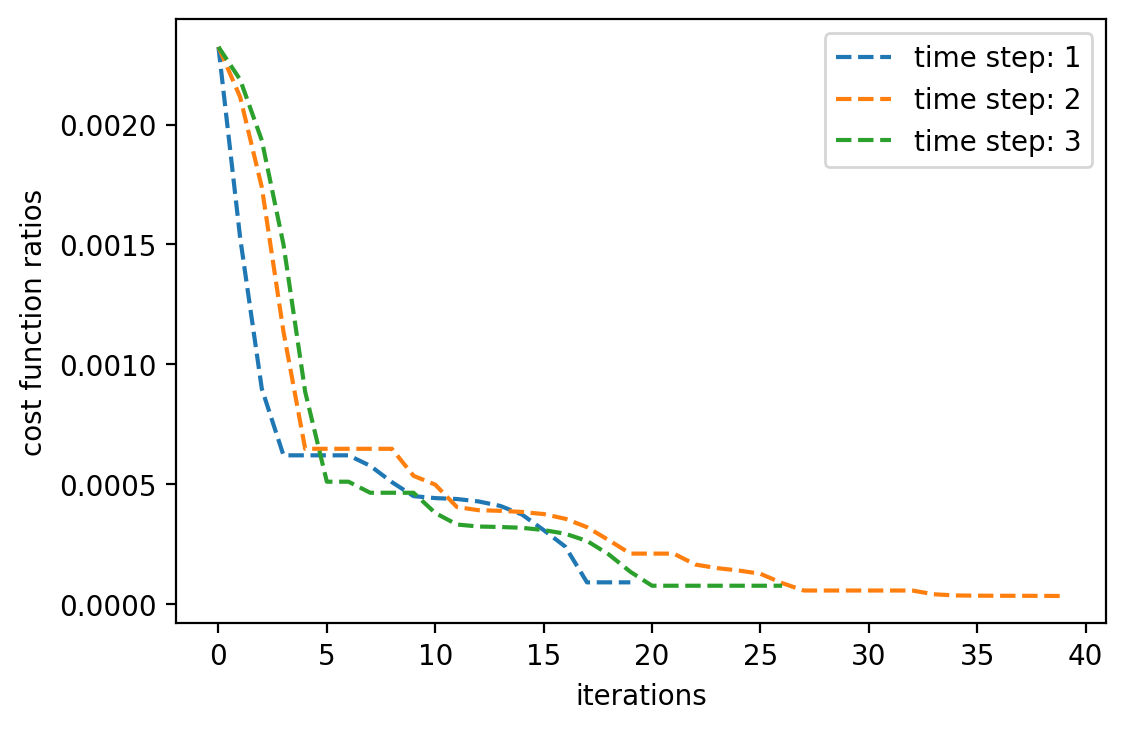

In [354]:
plt.figure(dpi=200)
plt.ylabel('cost function ratios')
plt.xlabel('iterations')
plt.plot(ratios_ts_1_sp, '--', label='time step: 1')
plt.plot(ratios_ts_2_sp, '--', label='time step: 2')
plt.plot(ratios_ts_3_sp, '--', label='time step: 3')
plt.legend()

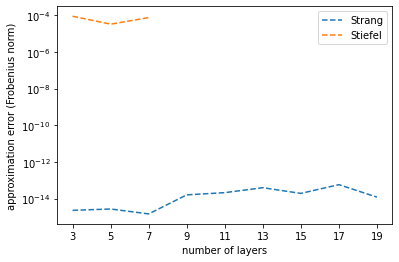

In [357]:
ax = plt.gca()
plt.ylabel('approximation error (Frobenius norm)')
plt.xlabel('number of layers')
plt.semilogy(error_suzuki_sp, '--', label='Strang')
plt.semilogy(error_stiefel_sp, '--', label='Stiefel')
set_discrete_labels(labels=[str(index) for index in (2*np.arange(1,len(error_suzuki_sp)+1) + 1)], ax=ax, rotation=0)
plt.legend()